# Time Series Prediction with LSTM Using PyTorch

In [1]:
import os
import sys
import time
import errno
import time
import timeit

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline 

In [3]:
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import tensorflow

In [4]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on torch: v{}'.format(torch.__version__))
print('Running on tensorflow: v{}'.format(tensorflow.__version__))

Running on numpy: v1.21.5
Running on torch: v1.10.2+cu102
Running on tensorflow: v2.8.0


In [5]:
import warnings
warnings.simplefilter("ignore")

In [6]:
from matplotlib import rcParams

rcParams.update({'font.size': 15})

In [7]:
cwd = os.getcwd()
cwd

'/data/TimeSeriesForcasting'

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# data

In [10]:
y_data=np.load(os.path.join(cwd+'/data_timeseries/', 'y_mck.npy'))

In [11]:
y_data.shape

(1000,)

In [12]:
x_data = np.linspace(0, 1000, y_data.shape[0]).reshape(-1, 1)
x_data.shape

(1000, 1)

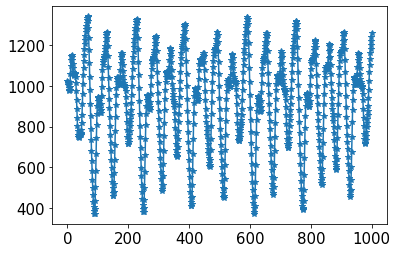

In [13]:
plt.plot(x_data, y_data, '-*');

In [14]:
# lets assume the last 200 elements are unseen!

In [15]:
training_set=y_data[0:800,np.newaxis]
training_set.shape

(800, 1)

In [16]:
sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

In [17]:
seq_length = 10
x, y = sliding_windows(training_data, seq_length)

x.shape, y.shape

((789, 10, 1), (789, 1))

In [18]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size
train_size, test_size

(528, 261)

In [19]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [20]:
dataX.shape, dataY.shape,  trainX.shape, trainY.shape, testX.shape,testY.shape

(torch.Size([789, 10, 1]),
 torch.Size([789, 1]),
 torch.Size([528, 10, 1]),
 torch.Size([528, 1]),
 torch.Size([261, 10, 1]),
 torch.Size([261, 1]))

### LSTM pytorch

In [21]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [22]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

In [23]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

In [24]:
start_time = time.time()

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
print("--- training took: %s seconds ---" % (time.time() - start_time))    

Epoch: 0, loss: 0.16690
Epoch: 100, loss: 0.00527
Epoch: 200, loss: 0.00108
Epoch: 300, loss: 0.00068
Epoch: 400, loss: 0.00054
Epoch: 500, loss: 0.00043
Epoch: 600, loss: 0.00034
Epoch: 700, loss: 0.00026
Epoch: 800, loss: 0.00019
Epoch: 900, loss: 0.00013
Epoch: 1000, loss: 0.00012
Epoch: 1100, loss: 0.00012
Epoch: 1200, loss: 0.00011
Epoch: 1300, loss: 0.00011
Epoch: 1400, loss: 0.00011
Epoch: 1500, loss: 0.00010
Epoch: 1600, loss: 0.00009
Epoch: 1700, loss: 0.00008
Epoch: 1800, loss: 0.00007
Epoch: 1900, loss: 0.00006
--- training took: 9.038275957107544 seconds ---


In [25]:
dataX.shape

torch.Size([789, 10, 1])

In [26]:
lstm.eval()
train_predict = lstm(dataX)

In [27]:
train_predict.shape

torch.Size([789, 1])

In [28]:
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

In [29]:
data_predict.shape, dataY_plot.shape

((789, 1), (789, 1))

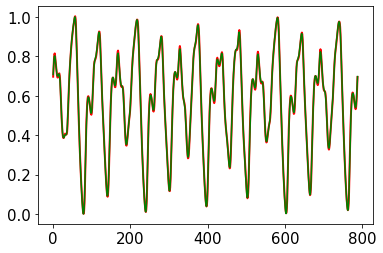

In [30]:
plt.plot(data_predict, 'r', lw=2)
plt.plot(dataY_plot, 'green')
plt.show()

In [31]:
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

In [32]:
data_predict.shape, dataY_plot.shape

((789, 1), (789, 1))

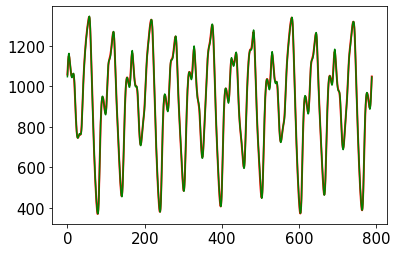

In [33]:
plt.plot(dataY_plot, 'r', lw=2)
plt.plot(data_predict, 'green')
plt.show()

what will be the signal from 800 to 1000?

### LSTM tensorflow

In [34]:
#### LSTM 
import itertools
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning, i.e. lagged time-series is input, next value is target
def predict_optimize_LSTM(X_,n_predict, n_valid,n_testper, windows=range(3,4), lstmsizes=range(1,3),
                         trainepochs=35, testepochs=40):
    X_ = X_[:,np.newaxis]
    rmses=[]
    forecasts=[]
    def create_dataset(dataset, look_back=3):
        dataX, dataY = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back), 0]
            dataX.append(a)
            dataY.append(dataset[i + look_back, 0])
        return np.array(dataX), np.array(dataY)
    dataset = X_.astype('float32')
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    for window,lstmsize in list(itertools.product(windows,lstmsizes)):
        # split into train and test sets
        train, test = dataset[:-n_predict-n_valid-window,:], dataset[-n_predict-n_valid-window:-n_predict-window,:]
        # reshape into X=t and Y=t+1
        look_back = window
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)

        # reshape input to be [samples, time steps, features]
        trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
        testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


        # create and fit the LSTM network
        model = Sequential()
        model.add(LSTM(lstmsize, input_shape=(1, look_back)))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        _ = model.fit(trainX, trainY, epochs=trainepochs, batch_size=1, verbose=0)
        # make predictions
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)
        # invert predictions
        trainPredict = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([trainY])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([testY])
        rmses.append(np.sqrt(np.sum( (testY[0] - testPredict[:,0])**2)))
    
    # now use best model ###############################
    window, lstmsize  =  list(itertools.product(windows,lstmsizes))[np.argmin(rmses)]
    train, test = dataset[:-n_predict-window,:], dataset[-n_predict-window:,:]
    # reshape into X=t and Y=t+1
    look_back = window
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    testX = np.append(testX, np.array(dataset[-look_back-1:-1]).T,0)
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(lstmsize, input_shape=(1, look_back)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    _ = model.fit(trainX, trainY, epochs=testepochs, batch_size=1, verbose=0)
    # make predictions
    testPredict = model.predict(testX)

    testPredict = scaler.inverse_transform(testPredict)
    return model, [window, lstmsize], testPredict
    # shift train predictions for plotting
#%%

In [35]:
n_predict = 200
n_testper = 1  
n_valid = 100

In [36]:
look_back=10
window = look_back

In [37]:
Y=training_set[:,0]
Y.shape

(800,)

In [38]:
X = np.linspace(0, 1000, num=1000).reshape(-1, 1)
X.shape

(1000, 1)

In [39]:
start_time = time.time()

lstm, params, Y_lstm = predict_optimize_LSTM(Y,n_predict, n_valid,n_testper, 
                                              windows=range(20,30,1), lstmsizes=range(1,4),
                                              trainepochs=30, testepochs=40)

print("--- predict_optimize_LSTM took: %s seconds ---" % (time.time() - start_time))

--- predict_optimize_LSTM took: 965.2460486888885 seconds ---


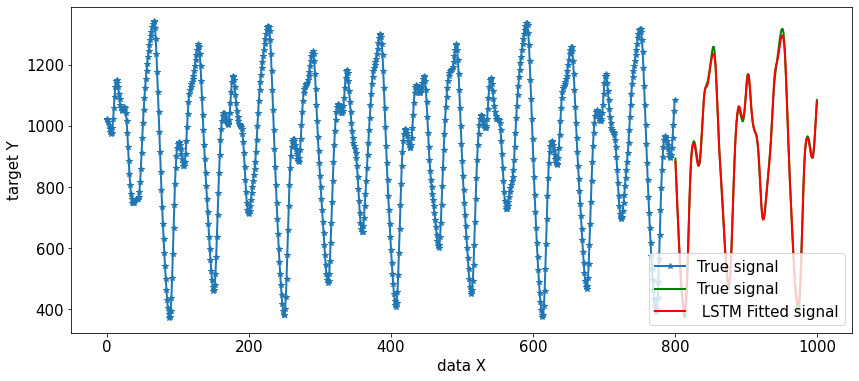

In [40]:
fig = plt.figure(figsize=(14,6))

plt.plot(X[0:-n_predict], Y, '-*',  label="True signal", linewidth=2)

plt.plot(X[-n_predict:], Y[-n_predict:],  label="True signal", color='g',  linewidth=2)
plt.plot(X[-n_predict:], Y_lstm[-n_predict:], label=" LSTM Fitted signal", color='r',  linewidth=2)

plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
plt.show()